# Tugas Modul Convolutional Neural Network

## MobileNet

### Import Library
- Tahap pertama adalah import seluruh library yang dibutuhkan


In [91]:
# Import library
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

# Penjelasan
# Layers digunakan untuk menambahkan lapisan ke dalam model
# ImageDataGenerator digunakan untuk melakukan augmentasi pada gambar
# Sequential digunakan untuk membuat model secara berurutan
# Conv2D digunakan untuk membuat Lapisan konvolusi
# MaxPooling2D digunakan untuk melakukan pooling pada lapisan konvolusi
# Dense digunakan untuk membuat Lapisan fully connected
# Dropout digunakan untuk menghindari overfitting
# Flatten digunakan untuk membuat lapisan menjadi flat (rata) menjadi vektor 1 dimensi

### Load Data
- Load dataset berdasarkan path dimana dataset disimpan

In [92]:
count = 0  # digunakan untuk menghitung jumlah gambar
dirs = os.listdir(r'D:\ATMAJAYA\Semester5\PMDPL\Tugas6_A_11648\train_data')

for dir in dirs:
    # Ensure there's a separator between the directory and the folder name
    files = list(os.listdir(os.path.join(r'D:\ATMAJAYA\Semester5\PMDPL\Tugas6_A_11648\train_data', dir)))
    print(dir + ' Folder has ' + str(len(files)) + ' Images')
    count += len(files)  # Increment count by the number of files

print('Images Folder has ' + str(count) + ' Images')

Matang Folder has 800 Images
Mentah Folder has 800 Images
Images Folder has 1600 Images


### Load Images into Arrays as Dataset
- Membuat dataset dari gambar yang ada di direktori

In [93]:
# Parameter
base_dir = r'D:\ATMAJAYA\Semester5\PMDPL\Tugas6_A_11648\test_data' #direktori folder dataset
img_size = 180 #mengubah ukuran gambar menjadi 180
batch = 32 #jumlah sample (gambar) yang akan diproses pada satu kali iterasi
validation_split = 0.1 #data pelatihan yang akan digunakan sebagai data validasi

- Memasukkan parameter yang telah di definisikan tadi untuk membuat dataset dari gambar di direktori


In [94]:
dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir, #path direktori, subfolder dianggap sebagai label
    seed=123, #untuk memastikan proses pemisahan data selalu konsisten (random_state)
    image_size=(img_size, img_size), #ukuran gambar diubah (resize) menjadi 180x180 pixel
    batch_size=batch, #jumlah gambar yang akan dikelompokkan 
)

Found 80 files belonging to 2 classes.


In [95]:
#mendapatkan nama kelas dari dataset 
class_names = dataset.class_names #dataset.class_names akan mengambil daftar nama kelas berdasarkan subfolder di dalam direktori
print("Class Names:", class_names)

Class Names: ['Matang', 'Mentah']


### Train-Validation-Test Split
- Membagi dataset menjadi tiga subset yaitu train, validation, dan test
    - Train, digunakan untuk melatih model agar mengenali pola dalam data
    - Validation, digunakan untuk mengevaluasi performa model selama pelatihan
    - Test, digunakan untuk menguji model setelah pelatihan

In [96]:
total_count = len(dataset) #menghitung jumlah total gambar dalam dataset
val_count = int(total_count * validation_split) #menghitung jumlah gambar untu
train_count = total_count - val_count # menghitung jumlah gambar untuk train
###Terdapat code yang hilang disini! lihat modul untuk menemukanya menghitung jumlah gambar untuk train

print("Total Images:", total_count)
print("Train Images:", train_count)
print("Validation Images:", val_count)

Total Images: 3
Train Images: 3
Validation Images: 0


In [97]:
train_ds = dataset.take(train_count)
val_ds = dataset.skip(train_count)

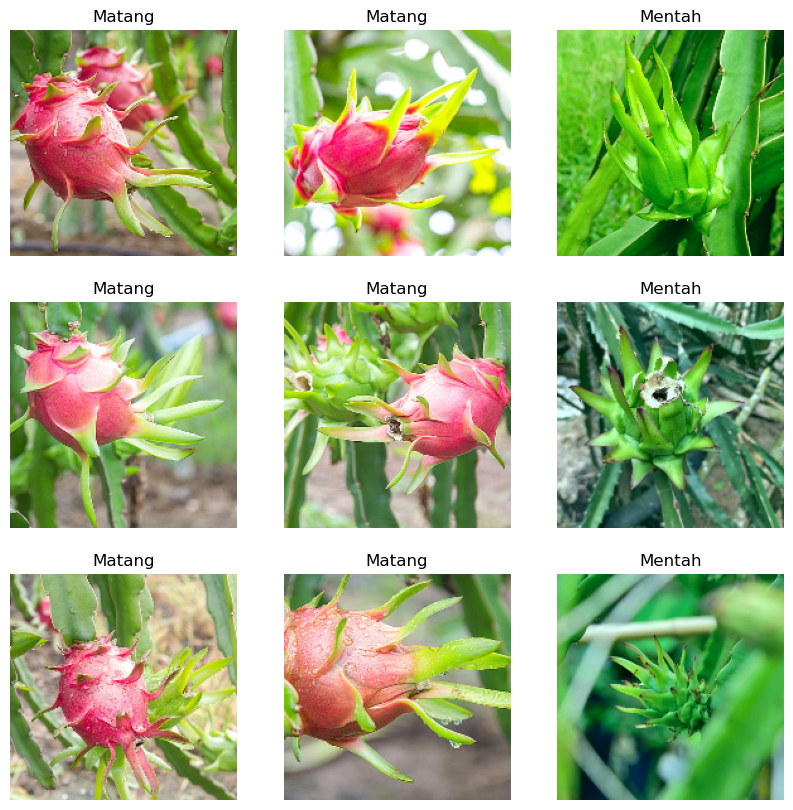

In [98]:
import matplotlib.pyplot as plt

i = 0

# Mengatur ukuran figure
plt.figure(figsize=(10, 10))  # Perbaiki 'ligmasize' menjadi 'figsize'

# Mengambil satu batch dari train_ds
for images, labels in train_ds.take(1):  # Mengambil 1 batch pertama dari train_ds
    for i in range(9):  # Menampilkan 9 gambar
        plt.subplot(3, 3, i + 1)  # Menyiapkan subplot dengan grid 3x3 dan menempatkan gambar pada posisi i+1
        plt.imshow(images[i].numpy().astype('uint8'))  # Menampilkan gambar dan mengonversi ke tipe uint8
        plt.title(class_names[labels[i]])  # Menampilkan judul gambar sesuai dengan nama kelas
        plt.axis('off')  # Menonaktifkan sumbu pada gambar agar tidak terlihat

plt.show() # Menampilkan semua gambar yang telah disiapkan

In [99]:
import numpy as np

# Tampilkan gambar dengan shape (32, 180, 180, 3)
for images, labels in train_ds.take(1):
    images_array = np.array(images)
    print(images_array.shape)  # Output: (32, 180, 180, 3)
    #32: Jumlah gambar dalam batch.
    #180: Lebar gambar dalam piksel
    #180: Tinggi gambar dalam piksel
    #3: Jumlah channel gambar (RGB)

(32, 180, 180, 3)


In [100]:
#Mengatur AUTOTUNE untuk pemrosesan data otomatis oleh tensorflow
#AUTOTUNE digunakan untuk memungkinkan tensorflow mengoptimalkan jumlah thread secara otomatis saat memproses data
AUTOTUNE = tf.data.AUTOTUNE

In [101]:
#mengoptimalkan dataset pelatihan (train_ds)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
#cache digunakan untuk menyimpan dataser di memori agar lebih cepat diakses
#shuffle mengacak data dalam batch agar model tidak terlalu terlatih pada urutan tertentu
#prefetch untuk menyiapkan data batch berikutnya secara otomatis

In [102]:
#mengoptimalkan dataset validasi (val_ds) 
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

### Data Augmentation
- Digunakan untuk menambah variasi data pelatihan dengan membuat gambar baru dari yang sudah ada seperti dengan rotasi, flipping, zooming, dan sebagainy
- Untuk mengurangi overfitting dan memperbesar dataset tanpa mengumpulkan data baru

In [103]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)), #membalik gambar secara horizontal
    layers.RandomRotation(0.1), #merotasi gambar secara acak dalam kisaran 0°-36° (0.1 * 360)
    layers.RandomZoom(0.1) #melakukan zoom in/zoom out secara acak dengan rentang 10%
])

d:\Anaconda\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


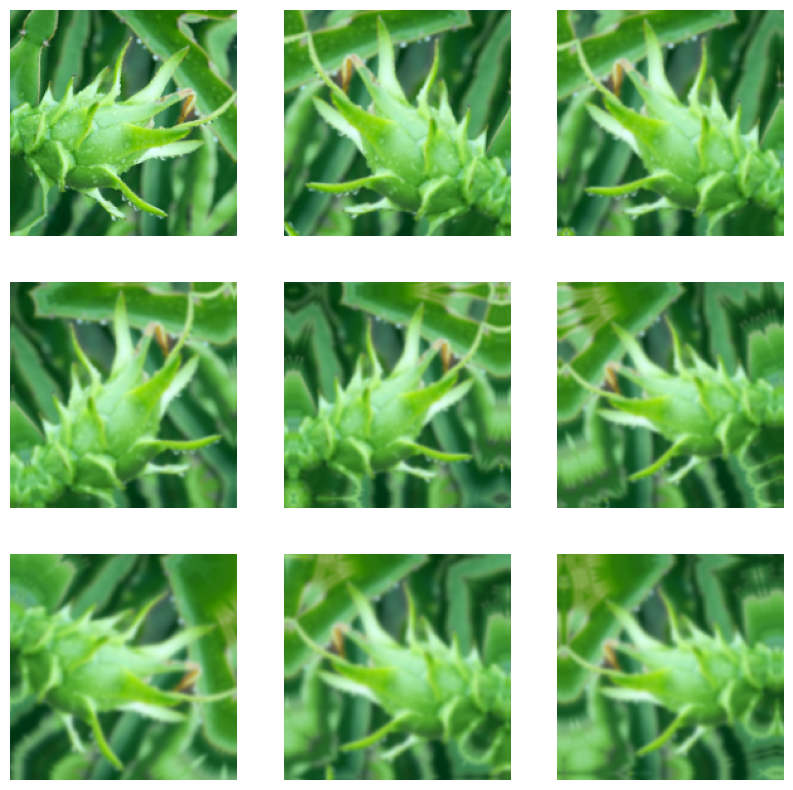

In [104]:
#sama seperti sebelumnya, code ini digunakan untuk menampilkan gambar dari data_augmentation
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

### MobileNet
- Salah satu algoritma yang dirancang untuk perangkat dengan keterbatasan sumber daya seperti smartphone

In [105]:
#import library yang dibutuhkan
from tensorflow.keras.applications import MobileNet #digunakan untuk memanfaatkan model yang sudah dilatih sebelumnya untuk pengenalan gambar
from tensorflow.keras.models import Model #digunakan untuk membuat dan mengonfigurasi arsitektur model

#membuat model dengan bobot yang telah dilatih sebelumnya
#include_top=False berarti tidak menggunakan lapisan klasifikasi dari mobilenet hanya bagian ekstraksi fitur
base_model = MobileNet(include_top=False, input_shape=(img_size, img_size, 3))

#membuka (unfreeze beberapa lapisan untuk proses fine tuning)
base_model.trainable = True #seluruh model bisa dilatih
fine_tune_at = len(base_model.layers) // 2  #menentukan bahwa setengah lapisan terakhir akan di unfreeze
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False #mengunci (freeze) lapisan pertama hingga setengah bagian pertama agar tidak dilatih kembali

#membuat model akhir dengan Lapisan tambahan
model = Sequential([
    data_augmentation,
    layers. Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])


C:\Users\A S U S\AppData\Local\Temp\ipykernel_20364\1249135469.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(include_top=False, input_shape=(img_size, img_size, 3))


In [106]:
from tensorflow.keras.optimizers import Adam #untuk mengoptimalkan proses pelatihan model

#mengkompilasi model dengan optimizer, loss function, dan metrics
model.compile(
    optimizer=Adam(learning_rate=1e-4), #menggunakan optimizer Adam dengan learning rate 0.0001
    loss='sparse_categorical_crossentropy', #untuk klasifikasi multi-kelas
    metrics=['accuracy'] #akurasi digunakan sebagai metrik evaluasi
)


In [107]:
#menampilkan ringkasan dari model
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 5, 5, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,360,322 (12.82 MB)

 Trainable params: 3,069,314 (11.71 MB)

 Non-trainable params: 291,008 (1.11 MB)

In [108]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping digunakan untuk menghentikan pelatihan lebih awal jika model tidak ada peningkatan
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max')

# Melatih model menggunakan data latih dan validasi dengan early stopping
history = model.fit(
    train_ds,                # Data pelatihan yang telah disiapkan
    epochs=30,               # Jumlah maksimal epoch
    validation_data=val_ds,  # Data validasi untuk mengevaluasi model pada setiap epoch
    callbacks=[early_stopping] # Menambahkan early stopping ke dalam callback untuk pelatihan
)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6552 - loss: 0.7292  
Epoch 2/30


d:\Anaconda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
d:\Anaconda\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step - accuracy: 0.8682 - loss: 0.3228
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step - accuracy: 0.9135 - loss: 0.2486
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step - accuracy: 0.9745 - loss: 0.1354
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 470ms/step - accuracy: 0.9807 - loss: 0.0850
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 502ms/step - accuracy: 0.9898 - loss: 0.0497
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step - accuracy: 1.0000 - loss: 0.0496
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 498ms/step - accuracy: 1.0000 - loss: 0.0299
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 423ms/step - accuracy: 1.0000 - loss: 0.0168
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 460ms/step - accuracy: 1.0000 - loss: 0.0306
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 1.0000 - loss: 0.0165
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step - accuracy: 1.0000 - loss: 0.0276
Epoch 13/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step - accuracy: 1.0000 - loss: 0.0078

KeyError: 'val_accuracy'

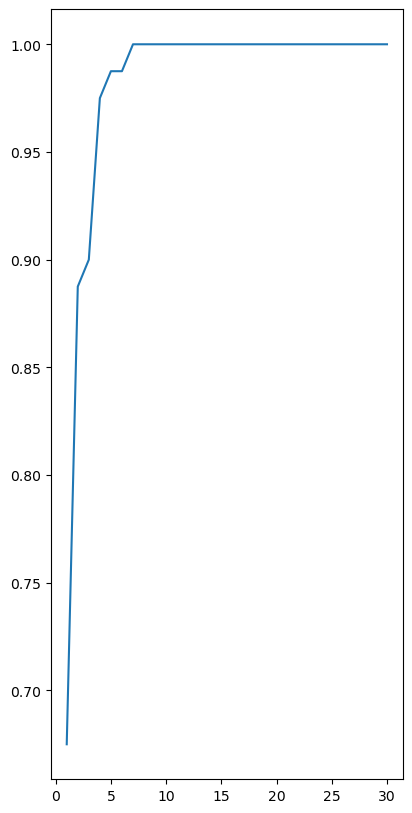

In [109]:
#membuat range untuk epoch berdasarkan panjang data loss dari pelatihan
ephocs_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(10, 10)) #membuat figure dengan ukuran 10x10 untuk menampilkan 2

#grafik pertama (Training and Validation Accuracy)
plt.subplot(1, 2, 1) #membuat subplot pertama dalam Layout 1 baris dan 2 kolom
plt.plot(ephocs_range, history.history['accuracy'], label='Training Accuracy') #plot
plt.plot(ephocs_range, history.history['val_accuracy'], label='Validation Accuracy' )
plt.legend(loc='lower right') #membuat Legenda (informasi elemen visual) di sudut kana
plt.xlim(0, 13) #mengatur batas nilai pada sumbu x dari epoch 1 sampai 13
plt.title('Training and Validation Accuracy') #memberi judul grafik

#grafik kedua (Training and Validation Loss)
plt.subplot(1, 2, 2)
plt.plot(ephocs_range, history.history['loss'], label='Training Loss')
plt.plot(ephocs_range, history.history['val loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlim(0, 13)
plt.title('Training and Validation Loss')
plt.show()

In [110]:
#menyimpan model yang telah dilatih
model.save('model_mobilenet.h5')

In [111]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

#memuat model yang sudah dilatih
model = load_model(r'D:\ATMAJAYA\Semester5\PMDPL\Tugas6_A_11648\model_mobilenet.h5')  # Ganti dengan path model Anda
class_names = ['Matang', 'Mentah'] #kelas yang ada pada model

#fungsi untuk mengklasifikasikan gambar dan menyimpan gambar asli
def classify_images(image_path, save_path='predicted_image.jpg'):
    try:
        #memuat dan mempersiapkan gambar untuk prediksi
        input_image = tf.keras.utils.load_img(image_path, target_size=(180, 180)) #membuat gambar dari path dan mnegubah ukurannya menjadi 180x180 pixel
        input_image_array = tf.keras.utils.img_to_array(input_image) #mengubah gambar jadi array numpy agar bisa di proses model
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)  #menambahkan dimensi batch agar sesuai dengan input model
                                                                    #dimensi menjadi (1, 180, 180, 3)

        #melakukan prediksi
        predictions = model.predict(input_image_exp_dim) #melakukan prediksi pada gambar yang telah diproses
        result = tf.nn.softmax(predictions[0]) #menghitung hasil prediksi menggunakan softmax untuk mendapatkan probabilitas tiap kelas
        class_idx = np.argmax(result) #menemukan indeks kelas dengan probabilitas tertinggi
        confidence = np.max(result) * 100 #menghitung confidence dalam persentase

        #menampilkan hasil prediksi dan confidence
        print(f"Prediksi: {class_names[class_idx]}") #menampilkan nama kelas yang diprediksi 
        print(f"Confidence: {confidence:.2f}%") #menampilkan nilai confidence

        #menyimpan gambar asli tanpa teks
        input_image = Image.open(image_path) #membuka gambar yang ada di path
        input_image.save(save_path) #menyimpan gambar asli ke dalam path yang telah ditentukan

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"

#contoh penggunaan fungsi
result = classify_images(r'D:\ATMAJAYA\Semester5\PMDPL\Tugas6_A_11648\test_data\Matang\Mature_Dragon_Original_Data0007.jpg', save_path='matang.jpg')
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediksi: Matang
Confidence: 73.11%
Prediksi: Matang dengan confidence 73.11%. Gambar asli disimpan di matang.jpg.


Found 80 files belonging to 2 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 748ms/step


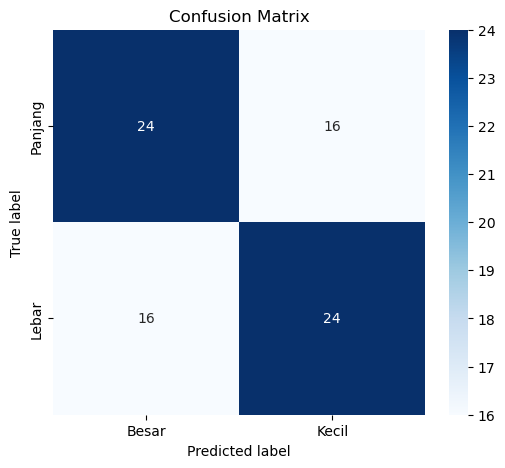

Confusion Matrix:
 [[24 16]
 [16 24]]
Akurasi: 0.6
Presisi: [0.6 0.6]
Recall: [0.6 0.6]
F1 Score: [0.6 0.6]


In [113]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt

#memuat model yang telah dilatih sebelumnya
mobileNet_model = load_model(r'D:\ATMAJAYA\Semester5\PMDPL\Tugas6_A_11648\model_mobilenet.h5')#gunakan path masing masing ya

#memuat data test yang sebenarnya
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    r'test_data', #direktori data uji
    labels='inferred', #label otomatis dari subfolder yang ada
    label_mode='categorical',  #menghasilkan label dalam bentuk one-hot encoding
    batch_size=32, #ukuran batch untuk pemrosesan
    image_size=(180, 180) #ukuran gambar yang akan diproses
)

#prediksi model
y_pred = mobileNet_model.predict(test_data)
y_pred_class = tf.argmax(y_pred, axis=1)  #konversi ke kelas prediksi

#ekstrak label sebenarnya dari test_data dan konversi ke bentuk indeks kelas
true_labels = [] #menyimpan label asli dalam bentuk indeks
for _, labels in test_data:
    true_labels.extend(tf.argmax(labels, axis=1).numpy())  #konversi one-hot ke indeks kelas
true_labels = tf.convert_to_tensor(true_labels) #mengkonversi list ke tensor untuk perhitungan

#membuat confusion matrix untuk evaluasi
conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class)

#menghitung akurasi berdasarkan confusion matrix
accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)

#mnghitung presisi dan recall dari confusion matrix
precision = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0)
recall = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)

#menghitung F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

#visualisasi Confusion Matrix
plt.figure(figsize=(6, 5)) #mengatur ukuran gambar
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues', #annot=True untuk menampilkan angka di dalam setiap sel matriks
                                                                 #fmt='d' untuk menampilkan bilangan bulat tanpa desimal
            xticklabels=["Besar", "Kecil"], yticklabels=["Panjang", "Lebar"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Menampilkan hasil
print("Confusion Matrix:\n", conf_mat.numpy())
print("Akurasi:", accuracy.numpy())
print("Presisi:", precision.numpy())
print("Recall:", recall.numpy())
print("F1 Score:", f1_score.numpy())
